In [1]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import nltk
from bs4 import BeautifulSoup
import re
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [2]:
data=pd.read_csv('train.tsv',delimiter='\t')

In [3]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
data=data.drop(['PhraseId','SentenceId'],axis=1)

In [5]:
data.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


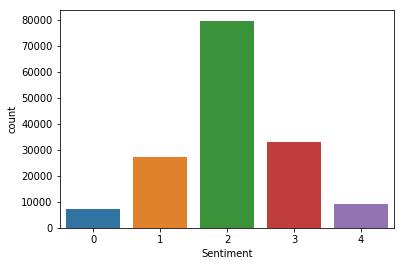

In [6]:
sns.countplot(data['Sentiment'])

### As the count of 0 and 4 is really small we shall merge those sentiments with 1 and 3.

In [7]:
data.loc[data['Sentiment'] == 0, 'Sentiment'] = 1
data.loc[data['Sentiment'] == 4, 'Sentiment'] = 3

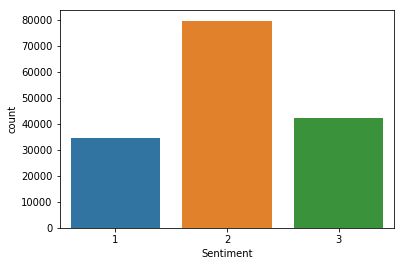

In [8]:
sns.countplot(data['Sentiment'])

In [9]:
def clean(words):
    x=BeautifulSoup(words).get_text()
    x=re.sub("[^a-zA-Z]"," ", words)
    x = x.lower()
    return x

In [10]:
data['Phrase']=data['Phrase'].apply(lambda x : clean(x))

/Users/ashish/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [11]:
data['Phrase']

0         a series of escapades demonstrating the adage ...
1         a series of escapades demonstrating the adage ...
2                                                  a series
3                                                         a
4                                                    series
                                ...                        
156055                                            hearst  s
156056                            forced avuncular chortles
156057                                   avuncular chortles
156058                                            avuncular
156059                                             chortles
Name: Phrase, Length: 156060, dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data["Phrase"], data["Sentiment"], test_size=0.3)

In [13]:
X_train.head()

51828                                            graceland
92447                                                   sa
6430     offers the flash of rock videos fused with sol...
46412    not only one of the best gay love stories ever...
32265                         breathe out of every frame  
Name: Phrase, dtype: object

In [14]:
tf=TfidfVectorizer(ngram_range=(2,2),stop_words='english')

In [15]:
X_train_tf=tf.fit_transform(X_train)

In [16]:
X_test_tf=tf.transform(X_test)

In [17]:
clf1 = GradientBoostingClassifier(n_estimators=100,max_depth=5)
clf2 = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=5)
nb=MultinomialNB(alpha=0.1)
cl4=CatBoostClassifier(iterations=100)
sclf = StackingClassifier(classifiers=[clf1, clf2,cl4], meta_classifier=nb,verbose=1,use_probas=True,use_features_in_secondary=True,drop_last_proba=True,average_probas=True)

In [18]:
sclf.fit(X_train_tf,y_train)

Fitting 3 classifiers...
Fitting classifier1: gradientboostingclassifier (1/3)
Fitting classifier2: randomforestclassifier (2/3)
Fitting classifier3: catboostclassifier (3/3)
0:	learn: 1.0942929	total: 1.05s	remaining: 1m 43s
1:	learn: 1.0902677	total: 1.65s	remaining: 1m 20s
2:	learn: 1.0865065	total: 2.24s	remaining: 1m 12s
3:	learn: 1.0829907	total: 2.81s	remaining: 1m 7s
4:	learn: 1.0797007	total: 3.38s	remaining: 1m 4s
5:	learn: 1.0765687	total: 3.96s	remaining: 1m 2s
6:	learn: 1.0736813	total: 4.53s	remaining: 1m
7:	learn: 1.0709778	total: 5.09s	remaining: 58.6s
8:	learn: 1.0684414	total: 5.67s	remaining: 57.4s
9:	learn: 1.0660664	total: 6.25s	remaining: 56.2s
10:	learn: 1.0638367	total: 6.81s	remaining: 55.1s
11:	learn: 1.0617339	total: 7.38s	remaining: 54.1s
12:	learn: 1.0597777	total: 7.95s	remaining: 53.2s
13:	learn: 1.0579354	total: 8.51s	remaining: 52.3s
14:	learn: 1.0561626	total: 9.08s	remaining: 51.4s
15:	learn: 1.0545452	total: 9.65s	remaining: 50.6s
16:	learn: 1.053024

StackingClassifier(average_probas=True,
          classifiers=[GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sa...verbose=0,
            warm_start=False), <catboost.core.CatBoostClassifier object at 0x1a215fc908>],
          drop_last_proba=True,
          meta_classifier=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=True, use_probas=True, verbose=1)

In [19]:
sclf.score(X_test_tf,y_test)

0.6944764834038191

In [20]:
print(classification_report(y_test,sclf.predict(X_test_tf)))

              precision    recall  f1-score   support

           1       0.67      0.57      0.62     10392
           2       0.69      0.79      0.74     23769
           3       0.73      0.61      0.66     12657

   micro avg       0.69      0.69      0.69     46818
   macro avg       0.70      0.66      0.67     46818
weighted avg       0.70      0.69      0.69     46818



In [21]:
print(confusion_matrix(y_test,sclf.predict(X_test_tf)))

[[ 5969  4085   338]
 [ 2436 18867  2466]
 [  440  4539  7678]]


In [22]:
probas = sclf.predict_proba(X_test_tf)

In [23]:
probas

array([[0.18795791, 0.57647612, 0.23556597],
       [0.01848716, 0.02923332, 0.95227952],
       [0.89774076, 0.09572448, 0.00653476],
       ...,
       [0.18795791, 0.57647612, 0.23556597],
       [0.18795791, 0.57647612, 0.23556597],
       [0.05401042, 0.10369036, 0.84229922]])